In [126]:
import glob, json, os
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths = glob.glob('./images/*.jpg')
img_paths.sort()

img_paths = img_paths[:3000]
img_paths[:2]

['./images\\066ca05fe3aec3766bf1d0232fae658bdbfdace6.jpg',
 './images\\06e564825ec3ad1fb815aaa52f75ab89fe001e13.jpg']

In [127]:
validation_annotations = json.load(
    open('./annotations.json', encoding="utf-8")
)

validation_annotations[:2]

[{'url': 'http://imgsrc.baidu.com/imgad/pic/item/5fdf8db1cb1349547c3ffc4c5c4e9258d1094af0.jpg',
  'image_id': '5558cb2dc29ead139c4a08258f1e6fb6a4bb65d3.jpg',
  'caption': ['一个戴着眼镜的男人在屋子里看书',
   '餐厅里有一个戴着眼镜的男人在看书',
   '屋子里有一个戴着眼镜的男人在看书',
   '一个戴着眼镜的男人在房屋里看桌子上的文件',
   '一个戴着眼镜的男人在餐厅里看书']},
 {'url': 'http://news.sogou.com',
  'image_id': '889f32f71d67d8396102f24a5fd3f3055e1a57e9.jpg',
  'caption': ['大厅里一个黑色上衣的女人在和一个男人交谈',
   '舞台上有一个面带微笑的男人在看着一个戴着眼镜的女人',
   '大厅里有一个穿着深色裤子的男人和一个戴着眼镜的女人在交谈',
   '屋子里有一个戴着眼镜的女人在和一个面带微笑的男人交谈',
   '舞台上有一个穿着深色裤子的男人看着一个右手扶着耳麦的女人']}]

In [128]:
validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}

In [129]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]

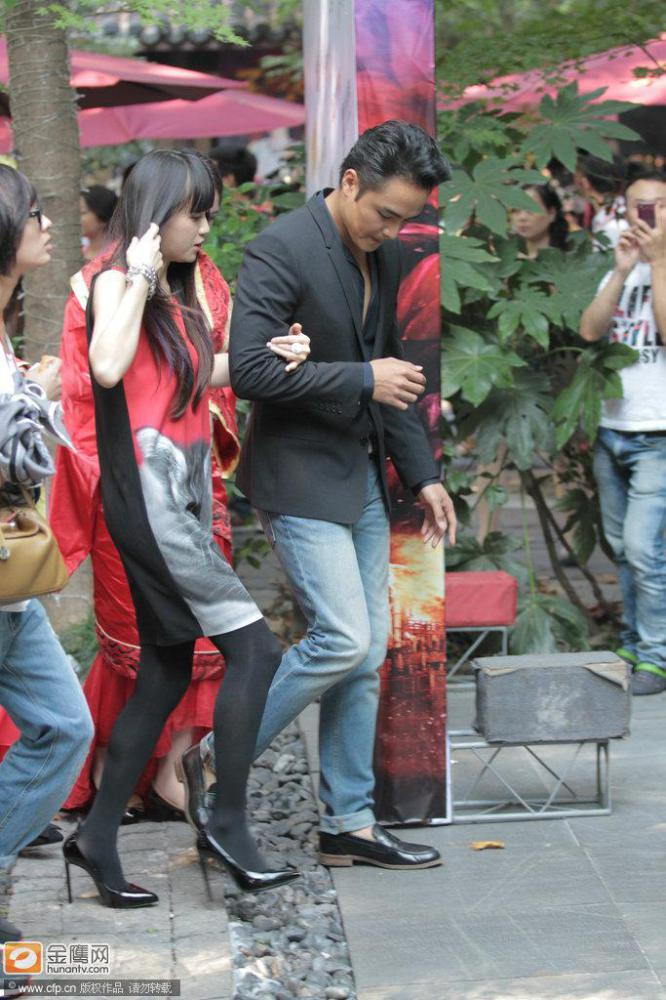

In [130]:
Image.open(img_paths[0])

In [131]:
img_captions[0]

'一个人前有一个右手撩头发的女人挽着一个穿着黑色上衣的男人走在道路上'

# 加载CLIP模型

In [132]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

model = ChineseCLIPModel.from_pretrained("../models/AI-ModelScope/chinese-clip-vit-base-patch16") # 中文clip模型
processor = ChineseCLIPProcessor.from_pretrained("../models/AI-ModelScope/chinese-clip-vit-base-patch16") # 预处理

# 图像编码

In [133]:
img_image_feat = []

batch_size = 20
for idx in tqdm(range(len(img_captions) // batch_size + 1)):
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)

    break
        
img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

  0%|          | 0/1 [00:00<?, ?it/s]

In [134]:
img_image_feat.shape # 20张图片 512 维度

(10, 512)

# 文本编码

In [135]:
img_texts_feat = []

batch_size = 20
for idx in tqdm(range(len(img_captions) // batch_size + 1)):
    texts = [ text for text in img_captions[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
    break
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

  0%|          | 0/1 [00:00<?, ?it/s]

In [136]:
img_texts_feat.shape

(10, 512)

# 尝试1：相似度计算

In [137]:
query_idx = 5

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) # 矩阵计算
sim_idx = sim_result.argsort()[::-1][1:4]

输入文本:  篮球场上有两个穿着运动服的男人在打篮球


([], [])

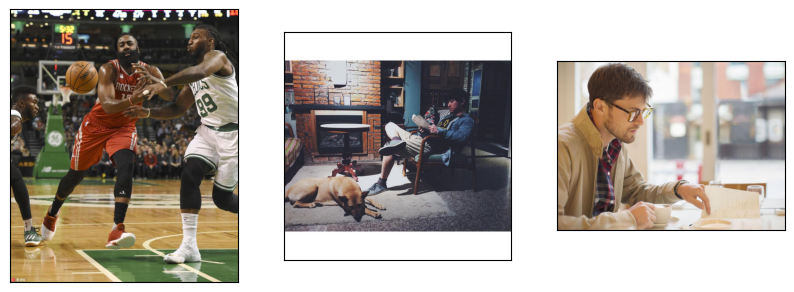

In [138]:
print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [139]:
query_idx = 5

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

文本识别结果:  ['篮球场上有两个穿着运动服的男人在打篮球', '一对双手拿着话筒的男女坐在展板前的沙发上', '一个人前有一个右手撩头发的女人挽着一个穿着黑色上衣的男人走在道路上']


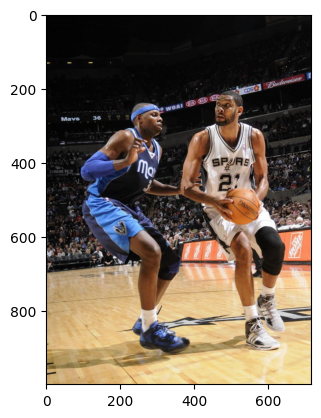

In [140]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [141]:
import jieba

In [142]:
jieba.lcut('今天天气很好，心情也很好。')

['今天天气', '很', '好', '，', '心情', '也', '很', '好', '。']

In [143]:
jieba.lcut(img_captions[0])

['一个',
 '人前',
 '有',
 '一个',
 '右手',
 '撩',
 '头发',
 '的',
 '女人',
 '挽',
 '着',
 '一个',
 '穿着',
 '黑色',
 '上衣',
 '的',
 '男人',
 '走',
 '在',
 '道路',
 '上']

In [144]:
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])

In [145]:
img_captions2words[:10]

['一个', '人前', '有', '一个', '右手', '撩', '头发', '的', '女人', '挽']

In [146]:
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [147]:
img_captions2words[:10]

['展板', '球衣', '头发', '篮球', '沙发', '运动服', '牵着', '行走', '男女', '戴着']

In [148]:
img_texts_feat = []

batch_size = 20
for idx in tqdm(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

  0%|          | 0/3 [00:00<?, ?it/s]

# 尝试2：标签相似度计算

In [149]:
query_idx = 8

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

文本识别结果:  ['休闲', '脚下', '小孩', '沙滩', '人前', '牵着']


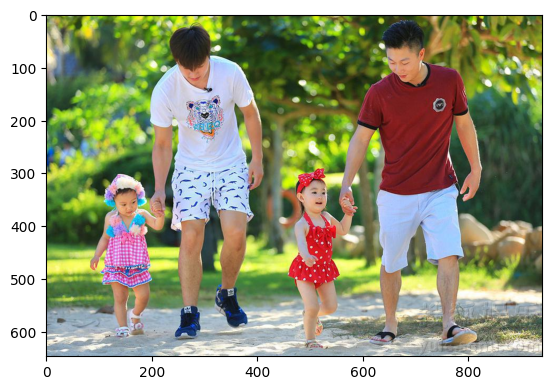

In [150]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])